# Implementing a GPT model from scratch to generate text

In [9]:
GPT_CONFIG_124M = {
        "vocab_size": 50257, # Vocabulary size
        "context_length": 1024, # Context length
        "emb_dim": 768, # Embedding dimension
        "n_heads": 12, # Number of attention heads
        "n_layers": 12, # Number of layers
        "drop_rate": 0.1, # Dropout rate
        "qkv_bias": False # Query-Key-Value bias
}

We will code a GPT model following:

- 1) GPT backbone
- 2) Layer Normalization
- 3) GELU activation
- 4) Feed forward network
- 5) Shortcut connections
- 6) Transformer block
- 7) Final GPT architecture

## 1) GPT backbone model architecture class

In [10]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential( # placeholder for TransformerBlock
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = DummyLayerNorm(cfg["emb_dim"]) # placeholder for LayerNorm
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward (self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)

        logits = self.out_head(x)
        return logits
    
class DummyTransformerBlock(nn.Module): # placeholder to be replaced by a real transformer block
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x
    
class DummyLayerNorm(nn.Module): # to be replaced by layernorm interface
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

In [11]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [12]:
# initialize a 124M param model instance and feed it with the batch
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:" , logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


## 2) Layer Normalization

In [13]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [14]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [15]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [16]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [17]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5 # prevent div by 0 during normalization
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False) # use biased variance, so div by n, not n-1
        # this is practically negligible for large n, but matches the original GPT-2 implementation
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [18]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Normalized layer outputs:\n", out_ln)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>)
Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Layer norm normalizes each input independently of the batch size, it offers more flexibility and stability where resources are limited.

## 3) GELU activation

In [19]:
# implementation of the GELU activation function
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) *
        (x + 0.044715 * torch.pow(x, 3))
        ))

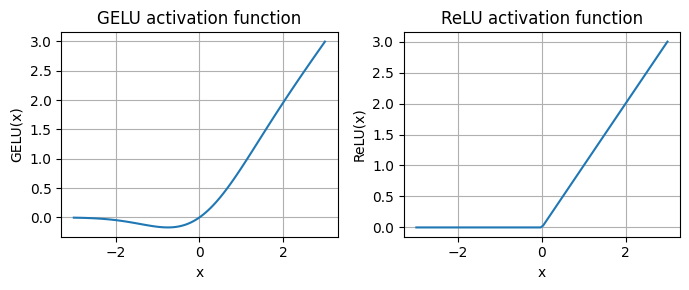

In [20]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(7, 3))

for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()
    


## 4) Feed forward network

In [21]:
# implementing feed forward layer with GELU activation
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], cfg["emb_dim"] * 4),
            GELU(),
            nn.Linear(cfg["emb_dim"] * 4, cfg["emb_dim"])
        )
    
    def forward(self, x):
        return self.layers(x)

In [ ]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) # 2, 3 e.g.
out = ffn(x)
print(out.shape)
print(out)

# inputs are projected to 4 times the embedding dimension, passed through the GELU activation function, 
# and then projected back to the original embedding dimension

torch.Size([2, 3, 768])
tensor([[[ 0.1238,  0.0457,  0.0939,  ...,  0.1107,  0.0167, -0.1992],
         [ 0.1574, -0.0282,  0.0049,  ...,  0.0026,  0.1120, -0.1075],
         [ 0.1184, -0.0052,  0.0839,  ...,  0.1662,  0.0112, -0.1685]],

        [[ 0.1302,  0.0630,  0.1050,  ...,  0.1439,  0.0562, -0.1128],
         [ 0.1249, -0.0073,  0.1022,  ...,  0.0417,  0.0381, -0.0828],
         [ 0.0494,  0.0654,  0.0347,  ...,  0.0701,  0.0793, -0.1810]]],
       grad_fn=<ViewBackward0>)


In [23]:
# cool way to visualize high-dimensional tensors
tensor_4d = torch.randint(0, 10, (2, 3, 2, 2))  # Random 4D tensor

print("Tensor shape:", tensor_4d.shape)

# Iterate over the first two dimensions
for b in range(tensor_4d.shape[0]):  # Batch
    for c in range(tensor_4d.shape[1]):  # Channel
        print(f"Batch {b}, Channel {c}:")
        print(tensor_4d[b, c])  # Each is a 2x2 matrix


Tensor shape: torch.Size([2, 3, 2, 2])
Batch 0, Channel 0:
tensor([[8, 2],
        [5, 2]])
Batch 0, Channel 1:
tensor([[9, 3],
        [8, 4]])
Batch 0, Channel 2:
tensor([[5, 0],
        [6, 5]])
Batch 1, Channel 0:
tensor([[7, 9],
        [7, 2]])
Batch 1, Channel 1:
tensor([[6, 2],
        [2, 2]])
Batch 1, Channel 2:
tensor([[8, 4],
        [5, 6]])


## 5) Shortcut connections (residual connections)

In deep networks, especially those with many layers (like GPT or ResNets), vanishing gradients can prevent the network from learning effective features because the early layers receive negligible updates during training. Residual connections mitigate this by ensuring that gradients have a clear, strong path to flow back through, thereby allowing more effective training of deep architectures.

In [128]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([ # five layers with GELU activation
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),
                    GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),
                    GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),
                    GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),
                    GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),
                    GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x) # compute output of each layer
            if self.use_shortcut and x.shape == layer_output.shape: # check if shortcut can be used
                x = x + layer_output
            else:
                x = layer_output
        return x
        

In [129]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [130]:
# let's implement a function that computes the gradients in the model backward pass

def print_gradients(model, x):
    output = model(x) # forward pass
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target) # compute loss based on how close the output is to the target

    loss.backward() # backward pass to compute gradients

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [131]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152039906941354
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [132]:
# gradient becoming smaller as we progress to the earlier layers (vanishing gradient problem)
# let's now compare it with the model that uses the shortcut

torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


- Gradient stabilized as we progress from earlier layers (though layer 4 has a slightly higher gradient)

- The particularly high gradient in layer 4 is likely due to its proximity to the loss and possibly the cumulative effect of the residual connections. This isn’t necessarily a problem.

## 6) Transformer block

In [134]:
# we import previous MultiHeadAttention class from previous chapters:

# now, with weight-splits combining both the wrapper and causal attention
# multi-head attention class should split the input into multiple heads

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out,
                context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # reduces the projection dim to match desired output dim
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out) # uses linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) # split matrix adding num_heads dim
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim) # Then we unroll the last dim: d_out -> num_heads, head_dim
        values = values.view(b, num_tokens, self.num_heads, self.head_dim) # output (b, num_tokens, num_heads, head_dim)

        keys = keys.transpose(1, 2) # transpose from b, num_tokens, num_heads, head_dim -->
        queries = queries.transpose(1, 2) # b, num_heads, num_tokens, head_dim
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2) # transpose back to b, num_tokens, num_heads, head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out) # reshape to b, num_tokens, d_out
        context_vec = self.out_proj(context_vec) # adds optional linear projection
        return context_vec

In [137]:
# define a class for the transformer block that uses the multi-head attention class

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            dropout=cfg["drop_rate"],
            num_heads=cfg["n_heads"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut= nn.Dropout(cfg["drop_rate"])

    def forward(self, x):

        shortcut = x # shortcut connection for attn block
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut # add the original input to the output of the attn block

        shortcut = x # shortcut connection for ff block
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut # add the original input to the output of the ff layer
        return x

- We defined the `TransformerBlock` class including `MultiHeadAttention`and a feed forward network, both using the `cgf` dict from gpt config params.

- Layer normalization (LayerNorm) is applied before each of these two components,
and dropout is applied after them to regularize the model and prevent overfitting. This
is also known as Pre-LayerNorm. Older architectures, such as the original transformer
model, applied layer normalization after the self-attention and feed forward networks
instead, known as Post-LayerNorm, which often leads to worse training dynamics.

In [141]:
torch.manual_seed(123)
x = torch.rand(2, 4 , 768) # batch, num_tokens, emb_dim
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("\nOutput shape:", output.shape)
print(output)

Input shape: torch.Size([2, 4, 768])

Output shape: torch.Size([2, 4, 768])
tensor([[[-0.0055,  0.0972, -0.1122,  ...,  1.2889,  0.2623,  0.6685],
         [ 0.0023, -0.2369,  0.1720,  ...,  0.5952,  0.2497,  0.7447],
         [ 0.4673,  0.4472,  0.1791,  ...,  1.2525,  0.3045,  0.7750],
         [ 0.0662,  0.7224,  0.9206,  ...,  0.4790,  0.7428,  0.7015]],

        [[ 0.3622,  1.2144,  0.5221,  ...,  0.1854,  0.0111, -0.5034],
         [-0.0225,  0.7789,  0.2770,  ...,  0.1734,  0.5419,  0.1143],
         [ 0.7425,  0.4013,  0.3211,  ...,  0.3268,  0.7523, -0.1642],
         [ 0.5745,  0.6241,  0.4410,  ...,  1.1963,  1.2650,  0.2243]]],
       grad_fn=<AddBackward0>)


 - The preservation of shape throughout the transformer block architecture is not
incidental but a crucial aspect of its design.

## 7) Final GPT architecture

First, we will redo a bit the dummy classes created in the beginning. Note that the transformer block is repeated n_layers times (12) in our version (GPT-2), while 48 times in the largest version.

In [144]:
# let's reuse the DummyGPTModel class 

import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential( # placeholder for TransformerBlock
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = DummyLayerNorm(cfg["emb_dim"]) # placeholder for LayerNorm
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward (self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)

        logits = self.out_head(x)
        return logits
    
class DummyTransformerBlock(nn.Module): # placeholder to be replaced by a real transformer block
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x
    
class DummyLayerNorm(nn.Module): # to be replaced by layernorm interface
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

In [145]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device) # select device to train
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

In [146]:
batch

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

In [147]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch shape:", batch.shape)
print("Output shape:", out.shape)
print(out)

Input batch shape: torch.Size([2, 4])
Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [148]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 163009536


The difference on 163M params opposed to 124M, relies on the "weight tying concept", which is a technique that allows the model to share the weights between the token embeddings and the output layer. The weight tying technique is used in the GPT-2 model to reduce the number of parameters and improve the training efficiency.

In [150]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


And removing the params from the output layer:

In [153]:
total_params_gpt2 = (
    total_params - sum(p.numel() for p in model.out_head.parameters())
)

print(f"Number of trainable parameters "
f"considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: 124,412,160


Now close to the 124M specified. Despite weight tying improving efficiency, author usually prefers to keep token embeddings and output layer separated. If we were to count the params in ffn module and those contained in the multi-head attention module, we can do:

In [168]:
def count_parameters(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

# Count parameters for the first transformer block
first_block = model.trf_blocks[0]
attn_params_block0 = count_parameters(first_block.att)
ffn_params_block0 = count_parameters(first_block.ff)

print("=== First Transformer Block ===")
print("Multi-head Attention parameters:", attn_params_block0)
print("Feed Forward parameters:", ffn_params_block0)

# Optionally, compute total parameters across all transformer blocks
total_attn_params = sum(count_parameters(block.att) for block in model.trf_blocks)
total_ffn_params  = sum(count_parameters(block.ff) for block in model.trf_blocks)

print("\n=== All Transformer Blocks ===")
print("Total Multi-head Attention parameters:", total_attn_params)
print("Total attn params == 1 block * n layers is: ", total_attn_params == attn_params_block0 * GPT_CONFIG_124M["n_layers"])
print("Total Feed Forward parameters:", total_ffn_params)
print("Total ffn params == 1 ffn * n layers is: ", total_ffn_params == ffn_params_block0 * GPT_CONFIG_124M["n_layers"])



=== First Transformer Block ===
Multi-head Attention parameters: 2360064
Feed Forward parameters: 4722432

=== All Transformer Blocks ===
Total Multi-head Attention parameters: 28320768
Total attn params == 1 block * n layers is:  True
Total Feed Forward parameters: 56669184
Total ffn params == 1 ffn * n layers is:  True


In [174]:
total_size_bytes

652038144

In [178]:
# computing memory size needed for the model

total_size_bytes = total_params * 4 # 4 bytes per param, assuming all parameters are float32
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total model size: {total_size_mb:.2f} MB")

Total model size: 621.83 MB


In [179]:
# Testing different model sizes from GPT-2 series

def print_model_info(config, model_name):
    torch.manual_seed(123)  # for reproducibility
    model = GPTModel(config)
    total_params = sum(p.numel() for p in model.parameters())
    total_size_bytes = total_params * 4  # 4 bytes per parameter (float32)
    total_size_mb = total_size_bytes / (1024 * 1024)
    
    print(f"=== {model_name} ===")
    print(f"Total parameters: {total_params:,}")
    print(f"Total model size: {total_size_mb:.2f} MB")
    print("="*40)
    return model

# GPT-2 Medium: 1,024-dimensional embeddings, 24 transformer blocks, 16 multi-head attention heads
GPT_CONFIG_medium = {
    "vocab_size": 50257,       # Vocabulary size (e.g., from GPT-2)
    "context_length": 1024,    # Maximum sequence length
    "emb_dim": 1024,           # Embedding dimension
    "n_heads": 16,             # Number of attention heads
    "n_layers": 24,            # Number of transformer blocks
    "drop_rate": 0.1,          # Dropout rate
    "qkv_bias": False          # Whether to use bias in query/key/value projections
}

# GPT-2 Large: 1,280-dimensional embeddings, 36 transformer blocks, 20 multi-head attention heads
GPT_CONFIG_large = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 1280,           # Embedding dimension
    "n_heads": 20,             # Attention heads
    "n_layers": 36,            # Transformer blocks
    "drop_rate": 0.1,
    "qkv_bias": False
}

# GPT-2 XL: 1,600-dimensional embeddings, 48 transformer blocks, 25 multi-head attention heads
GPT_CONFIG_XL = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 1600,           # Embedding dimension
    "n_heads": 25,             # Attention heads
    "n_layers": 48,            # Transformer blocks
    "drop_rate": 0.1,
    "qkv_bias": False
}

# Instantiate and print information for each model
model_medium = print_model_info(GPT_CONFIG_medium, "GPT-2 Medium")
model_large  = print_model_info(GPT_CONFIG_large,  "GPT-2 Large")
model_XL     = print_model_info(GPT_CONFIG_XL,     "GPT-2 XL")


=== GPT-2 Medium ===
Total parameters: 406,212,608
Total model size: 1549.58 MB
=== GPT-2 Large ===
Total parameters: 838,220,800
Total model size: 3197.56 MB
=== GPT-2 XL ===
Total parameters: 1,637,792,000
Total model size: 6247.68 MB


### *Generating text with the GPT model

In [180]:
def generate_text_simple(model, idx, max_new_tokens, context_size): # idx is a (batch, n_tokens) tensor
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] # crops current context if it exceeds context size
        with torch.no_grad():
            logits = model(idx_cond) # model generates logits for the next token

        logits = logits[:, -1, :] # selects the last token in the sequence: (batch, n_tokens, vocab_size) 
                                    #-> (batch, vocab_size)
        probas = torch.softmax(logits, dim=-1) # converts logits to probabilities
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) # selects the most likely token (batch, 1)
        idx = torch.cat([idx, idx_next], dim=-1) # appends the new token to the sequence, where idx has shape (batch, n_tokens+1)
    return idx


- The softmax function is monotonic, meaning it
preserves the order of its inputs when transformed into outputs. So, in practice, the
softmax step is redundant since the position with the highest score in the softmax out-
put tensor is the same position in the logit tensor. In other words, we could apply the
torch.argmax function to the logits tensor directly and get identical results. However,
I provide the code for the conversion to illustrate the full process of transforming log-
its to probabilities, which can add additional intuition so that the model generates the
most likely next token, which is known as "greedy decoding".

In [181]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [182]:
model.eval() # disable dropout since we are not training the model
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [183]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


Garbage as expected - some bench press is needed :D